In [ ]:
# Homework 2
import numpy as np
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import accuracy_score # other metrics too pls!
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor # more!
from sklearn.model_selection import KFold

# adapt this code below to run your analysis
# 1. Write a function to take a list or dictionary of clfs and hypers(i.e. use logistic regression), each with 3 different sets of hyper parameters for each
# 2. Expand to include larger number of classifiers and hyperparameter settings
# 3. Find some simple data
# 4. generate matplotlib plots that will assist in identifying the optimal clf and parampters settings
# 5. Please set up your code to be run and save the results to the directory that its executed from
# 6. Investigate grid search function

M = np.array([[1,2],[3,4],[4,5],[4,5],[4,5],[4,5],[4,5],[4,5]])
L = np.ones(M.shape[0])
n_folds = 5

data = (M, L, n_folds)

def run (clfs, data, clf_hyper={}):
  M, L, n_folds = data # unpack data container
  kf = KFold(n_splits=n_folds) # Establish the cross validation
  ret = {} # classic explication of results

  for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
    for clf in clfs:
      clf = clf(**clf_hyper) # unpack parameters into clf if they exist
      try:
          clf.fit(M[train_index], L[train_index])
      except ValueError:
          pass
      pred = clf.predict(M[test_index])
      ret[ids]= {'clf': clf,
                'train_index': train_index,
                'test_index': test_index,
                'accuracy': accuracy_score(L[test_index], pred)}
    return ret

clfs = ['LinearRegression','LogisticRegression','RandomForestClassifier']
hypers = [  
            {'C': [0.1,0.001,0.0001],
             'penalty': ['l1','l2','elasticnet','none'],
             'solver': ['lbfgs','liblinear','sag','saga']}
#            {'n_estimators': 100, 'max_depth': 5}
            ]



results = run(clfs,data, clf_hyper={})


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes, load_iris,load_digits
import matplotlib.pyplot as plt
import os
import logging
import warnings

#annoying so turned off for annoying convergence errors
warnings.filterwarnings('error')


logger = logging.getLogger('gridsearch')

data = load_iris()
data = load_digits()
X = data.data
y = data.target

#X = np.array([[1,2],[3,4],[4,5],[4,5],[4,5],[4,5],[4,5],[4,5]])
#y = np.ones(X.shape[0])
n_folds = 5

models_params = {'LinearRegression': {'model': LinearRegression(), 'parameters': {'fit_intercept': [True, False], 'positive':[True,False],'n_jobs': [-1]}},
              'RandomForestClassifier': {'model': RandomForestClassifier(), 'parameters': {'bootstrap':[True,False],'oob_score':[True,False],'criterion':['gini','entropy','log_loss'],'max_features':['sqrt','log2','None'],'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10],'n_jobs' :[-1]}},
              'LogisticRegression': {'model': LogisticRegression(), 'parameters': {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],'class_weight':['balanced','None'],'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.01, 0.001, 0.1, 1, 10],'n_jobs':[-1]}},
              'GradientBoostingRegressor': {'model':GradientBoostingRegressor(),'parameters':{'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],'learning_rate':[10,1,0.1,0.01,0.001],'criterion':['friedman_mse', 'squared_error', 'mse'],'max_features':['auto', 'sqrt', 'log2'],'alpha': [1.0,.8,.6,.4,.2,0.0]}}
             }

best_params = {}
best_score = 0

for model_name, model_dict in models_params.items():
    model = model_dict['model']
    params = model_dict['parameters']
    for key, values in params.items():
        for value in values:
            parameters = {key: value}
            score = train_and_evaluate(model_name, model, parameters, X,y)
            if score is None:
                logger.info(f'{model_name} has score of 0')
                continue
            if (model_name != 'LinearRegression' and score > best_score) or (model_name == 'LinearRegression' and score < best_score):
                best_params = parameters
                best_params['model_name'] = model_name
                best_score = score

print("Best parameters:", best_params)
print("Best score:",best_score)


def train_and_evaluate (model_name, model, parameters, X, y):
    kf = KFold(n_splits=n_folds, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        try:
            model.set_params(**parameters)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        except:
            logger.info(f"Error: One or more of the parameters {parameters} are not accepted by {model_name}")
            return None
        if model_name == 'LinearRegression':
            score = mean_squared_error(y_test, y_pred)
        else:
            score = model.score(X_test, y_test)
        scores.append(score)
    return scores


In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes, load_iris,load_digits
import matplotlib.pyplot as plt
import os
import logging
import warnings
from itertools import product
from time import sleep
from sklearn.exceptions import ConvergenceWarning

ConvergenceWarning('ignore')
warnings.filterwarnings('error')

def _get_param_combinations(param_dict):
    keys = param_dict.keys()
    values = param_dict.values()
    for item in product(*values):
        yield dict(zip(keys, item))

def _grid_search(X_data, y_data, models_params):
    results = {}
    for model_name, model_dict in models_params.items():
        model = model_dict['model']
        parameters = model_dict['parameters']
        param_combinations = _get_param_combinations(parameters)
        
        for param_set in param_combinations:
            model.set_params(**param_set)
            
            kf = KFold(n_splits=3)
            for train_index, test_index in kf.split(X_data):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_data[train_index], y_data[test_index]
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    if model_name == 'LinearRegression':
                        score = mean_squared_error(y_test, y_pred)
                    else:
                        score = model.score(X_test, y_test)
                    if model_name not in results:
                        results[model_name] = []
                    results[model_name].append({'parameters': param_set, 'score': score})
                    sleep(1)
                except ValueError or UserWarning:
                    pass
    return results


def full_grid_search(X_data, y_data, models_params):
    results = _grid_search(X_data, y_data, models_params)
    return results

diab = load_diabetes()

models_params = {   'LinearRegression':     {       
                                                'model': LinearRegression(), 
                                                'parameters': {'fit_intercept': [True,False]}
                                            },
                    'RandomForestClassifier': { 
                                                'model': RandomForestClassifier(), 
                                                'parameters': { 'criterion':['gini','entropy','log_loss'],
                                                                'max_features':['sqrt','log2'],
                                                                'n_estimators': [10, 50, 100], 
                                                                'max_depth': [None, 5, 10]}
                                                },
                    'LogisticRegression': {
                                                'model': LogisticRegression(), 
                                                'parameters': { 'solver':['lbfgs', 'sag', 'saga'],
                                                                'class_weight':['balanced','None'],
                                                                'penalty': ['l1', 'l2', 'elasticnet', None],
                                                                'C': [0.01, 0.001, 0.1, 1, 10],
                                                                'max_iter': [50000]}
                                            },
                    'GradientBoostingRegressor': {  'model':GradientBoostingRegressor(),
                                                    'parameters':{  'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                                    'learning_rate':[10,1,0.1,0.01,0.001],
                                                                    'criterion':['friedman_mse', 'squared_error'],
                                                                    'max_features':['sqrt', 'log2'],
                                                                    'alpha': [1.0,.8,.6,.4,.2,0.0]}
                                                }
                }


results = full_grid_search(diab.data, diab.target, models_params)
#print(results)



In [17]:
results['LinearRegression']

[{'parameters': {'fit_intercept': True}, 'score': 3034.2414203626154},
 {'parameters': {'fit_intercept': True}, 'score': 3253.20664674845},
 {'parameters': {'fit_intercept': True}, 'score': 2793.9946927742535},
 {'parameters': {'fit_intercept': False}, 'score': 29112.481780107624},
 {'parameters': {'fit_intercept': False}, 'score': 27192.41747970786},
 {'parameters': {'fit_intercept': False}, 'score': 26452.326079509967}]

In [66]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes, load_iris, load_digits
import matplotlib.pyplot as plt
import os
import pickle as pkl
import logging
import warnings
from itertools import product
from time import sleep
from sklearn.exceptions import ConvergenceWarning

ConvergenceWarning('ignore')
warnings.filterwarnings('error')

def _get_param_combinations(param_dict):
    keys = param_dict.keys()
    values = param_dict.values()
    for item in product(*values):
        yield dict(zip(keys, item))

def _grid_search(X_data, y_data, models_params,kf_splits=2):
    results = {}
    for model_name, model_dict in models_params.items():
        model = model_dict['model']
        parameters = model_dict['parameters']
        param_combinations = _get_param_combinations(parameters)
        
        for param_set in param_combinations:
            model.set_params(**param_set)
            
            kf = KFold(n_splits=kf_splits)
            for train_index, test_index in kf.split(X_data):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_data[train_index], y_data[test_index]
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    if model_name in ['LinearRegression', 'GradientBoostingRegressor']:
                        score = mean_absolute_error(y_test, y_pred)
                    else:
                        score = roc_auc_score(y_test, y_pred)
                    if model_name not in results:
                        results[model_name] = []
                    results[model_name].append({'parameters': param_set, 'score': score})
                    sleep(1)
                except ValueError:
                    pass
        with open(os.path.join(os.getcwd(), 'results.pkl'), 'wb') as f:
            pkl.dump(results, f)
    return results


def full_grid_search(X_data, y_data, models_params,kf_splits):
    results = _grid_search(X_data, y_data, models_params,kf_splits=kf_splits)
    return results

def plot_scores_by_model(results, *model_names):
    for model_name in model_names:
        model_results = results[model_name]
        scores = [result['score'] for result in model_results]
        plt.plot(scores)
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.title(model_name)
        plt.savefig(f'{model_name}_grid_search_scores.png')
    plt.show()

diab = load_diabetes()

models_params = {   'LinearRegression':     {       
                                                'model': LinearRegression(), 
                                                'parameters': {'fit_intercept': [True,False]}
                                            },
                    'RandomForestClassifier': { 
                                                'model': RandomForestClassifier(), 
                                                'parameters': { 'criterion':['gini','entropy','log_loss'],
                                                                'max_features':['sqrt','log2'],
                                                                'n_estimators': [10, 50, 100], 
                                                                'max_depth': [None, 5, 10]}
                                                },
                    'LogisticRegression': {
                                                'model': LogisticRegression(), 
                                                'parameters': { 'solver':['lbfgs', 'sag', 'saga'],
                                                                'class_weight':['balanced','None'],
                                                                'penalty': ['l1', 'l2', 'elasticnet', None],
                                                                'C': [0.01, 0.001, 0.1, 1, 10],
                                                                'max_iter': [50000]}
                                            },
                    'GradientBoostingRegressor': {  'model':GradientBoostingRegressor(),
                                                    'parameters':{  'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                                    'learning_rate':[10,1,0.1,0.01,0.001],
                                                                    'criterion':['friedman_mse', 'squared_error'],
                                                                    'max_features':['sqrt', 'log2'],
                                                                    'alpha': [1.0,.8,.6,.4,.2,0.0]}
                                                }
                }


results = full_grid_search( diab.data,diab.target, models_params,kf_splits=3)

#plot_scores_by_model(results, ('LogisticRegression','RandomForestClassifier','LinerRegression','GradientBoostinRegressor'))
#plot_scores(results, 'RandomForestClassifier')
#plot_scores(results, 'LogisticRegression')
#plot_scores(results, 'GradientBoostingRegressor')

In [68]:
results.keys()

dict_keys(['LinearRegression', 'GradientBoostingRegressor'])

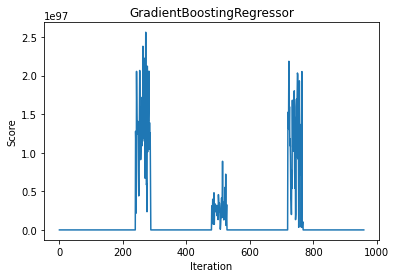

In [51]:
def plot_scores_by_model(results, *model_names):
    for model_name in model_names:
        model_results = results[model_name]
        scores = [result['score'] for result in model_results]
        plt.plot(scores)
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.title(model_name)
        plt.savefig(f'{model_name}_grid_search_scores.png')
    plt.show()
plot_scores_by_model(results, 'GradientBoostingRegressor')

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_diabetes, load_iris, load_digits

def evaluate_models(X, y, param_grid,cv=2):
    results = {}
    # Iterate over the models and their corresponding parameter grids
    for model_name, model_params in param_grid.items():
        model = model_params['model']
        params = model_params['parameters']
        grid_search = GridSearchCV(model, params, cv=cv)
        grid_search.fit(X, y)
        results[model_name] = {'best_score': grid_search.best_score_, 'best_params': grid_search.best_params_}
#        print(f'{model_name} best score: {grid_search.best_score_}')
#        print(f'{model_name} best parameters: {grid_search.best_params_}')
    return results

models_params = {   'LinearRegression':     {       
                                                'model': LinearRegression(), 
                                                'parameters': {'fit_intercept': [True,False]}
                                            },
                    'RandomForestClassifier': { 
                                                'model': RandomForestClassifier(), 
                                                'parameters': { 'criterion':['gini','entropy','log_loss'],
                                                                'max_features':['sqrt','log2'],
                                                                'n_estimators': [10, 50, 100], 
                                                                'max_depth': [None, 5, 10]}
                                                },
                    'LogisticRegression': {
                                                'model': LogisticRegression(), 
                                                'parameters': { 'solver':['lbfgs', 'sag', 'saga'],
                                                                'class_weight':['balanced','None'],
                                                                'penalty': ['l1', 'l2', 'elasticnet', None],
                                                                'C': [0.01, 0.001, 0.1, 1, 10],
                                                                'max_iter': [50000]}
                                            },
                    'GradientBoostingRegressor': {  'model':GradientBoostingRegressor(),
                                                    'parameters':{  'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                                    'learning_rate':[10,1,0.1,0.01,0.001],
                                                                    'criterion':['friedman_mse', 'squared_error'],
                                                                    'max_features':['sqrt', 'log2'],
                                                                    'alpha': [1.0,.8,.6,.4,.2,0.0]}
                                                }
                }


diab = load_diabetes()

results = evaluate_models(diab.data,diab.target,models_params)

ValueError: n_splits=10 cannot be greater than the number of members in each class.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, f1_score,log_loss
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes, load_iris, load_digits
import matplotlib.pyplot as plt
import os
import pickle as pkl
import logging
import warnings
from itertools import product
from time import sleep
from sklearn.exceptions import ConvergenceWarning

ConvergenceWarning('ignore')
warnings.filterwarnings('error')

def run(X_data, y_data, models_params,kf_splits):

    diab = load_diabetes()

    models_params = {   'LinearRegression':     {       
                                                'model': LinearRegression(), 
                                                'parameters': {'fit_intercept': [True,False]}
                                            },
                    'RandomForestClassifier': { 
                                                'model': RandomForestClassifier(), 
                                                'parameters': { 'criterion':['gini','entropy','log_loss'],
                                                                'max_features':['sqrt','log2'],
                                                                'n_estimators': [10, 50, 100], 
                                                                'max_depth': [None, 5, 10]}
                                                },
                    'LogisticRegression': {
                                                'model': LogisticRegression(), 
                                                'parameters': { 'solver':['lbfgs', 'sag', 'saga'],
                                                                'class_weight':['balanced','None'],
                                                                'penalty': ['l1', 'l2', 'elasticnet', None],
                                                                'C': [0.01, 0.001, 0.1, 1, 10],
                                                                'max_iter': [50000]}
                                            },
                    'GradientBoostingRegressor': {  'model':GradientBoostingRegressor(),
                                                    'parameters':{  'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                                    'learning_rate':[10,1,0.1,0.01,0.001],
                                                                    'criterion':['friedman_mse', 'squared_error'],
                                                                    'max_features':['sqrt', 'log2'],
                                                                    'alpha': [1.0,.8,.6,.4,.2,0.0]}
                                                }
                }


    results = full_grid_search( diab.data,diab.target, models_params,kf_splits=3)
    results.keys()

def _get_param_combinations(param_dict):
    keys = param_dict.keys()
    values = param_dict.values()
    for item in product(*values):
        yield dict(zip(keys, item))

def grid_search(X_data, y_data, models_params,kf_splits=2):
    results = {}
    for model_name, model_dict in models_params.items():
        model = model_dict['model']
        parameters = model_dict['parameters']
        param_combinations = _get_param_combinations(parameters)
        
        for param_set in param_combinations:
            model.set_params(**param_set)
            
            kf = KFold(n_splits=kf_splits)
            for train_index, test_index in kf.split(X_data):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_data[train_index], y_data[test_index]
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    if model_name in ['LinearRegression', 'GradientBoostingRegressor']:
                        score = mean_absolute_error(y_test, y_pred)
                    elif model_name in ['RandomForestClassifier','LogisticRegression']:
                        if model_name == 'LogisticRegression':
                            score = {
                                    'f1_score': f1_score(y_test, y_pred > 0.5),
                                    'log_loss': log_loss(y_test, y_pred)}
                        else:
                            score = roc_auc_score(y_test, y_pred)
                    if model_name not in results:
                        results[model_name] = []
                    results[model_name].append({'parameters': param_set, 'score': score})
                    #had IO issue so adding in 1 second sleep to get around this
                    sleep(1)
                except ValueError:
                    pass
        with open(os.path.join(os.getcwd(), 'results.pkl'), 'wb') as f:
            pkl.dump(results, f)
    return results


def full_grid_search(X_data, y_data, models_params,kf_splits):
    results = _grid_search(X_data, y_data, models_params,kf_splits=kf_splits)
    return results

def plot_scores_by_model(results, *model_names):
    for model_name in model_names:
        model_results = results[model_name]
        scores = [result['score'] for result in model_results]
        plt.plot(scores)
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.title(model_name)
        plt.savefig(f'{model_name}_grid_search_scores.png')
    plt.show()

if __name__ == '__main__':
    run()

In [ ]:
def grid_search(X_data, y_data, models_params,kf_splits=2):
    results = {}
    for model_name, model_dict in models_params.items():
        model = model_dict['model']
        parameters = model_dict['parameters']
        param_combinations = _get_param_combinations(parameters)
        
        for param_set in param_combinations:
            model.set_params(**param_set)
            
            kf = KFold(n_splits=kf_splits)
            for train_index, test_index in kf.split(X_data):
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y_data[train_index], y_data[test_index]
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    if model_name in ['LinearRegression', 'GradientBoostingRegressor']:
                        score = mean_absolute_error(y_test, y_pred)
                    elif model_name in ['RandomForestClassifier','LogisticRegression']:
                        if model_name == 'LogisticRegression':
                            score = {'roc_auc': roc_auc_score(y_test, y_pred),
                                    'f1_score': f1_score(y_test, y_pred > 0.5),
                                    'log_loss': log_loss(y_test, y_pred)}
                        else:
                            score = roc_auc_score(y_test, y_pred)
                    if model_name not in results:
                        results[model_name] = []
                    results[model_name].append({'parameters': param_set, 'score': score})
                    #had IO issue so adding in 1 second sleep to get around this
                    sleep(1)
                except ValueError:
                    pass
        with open(os.path.join(os.getcwd(), 'results.pkl'), 'wb') as f:


In [ ]:
[('LinearRegression', {'model': LinearRegression(), 'parameters': {'fit_intercept': [True, False]}}),
 ('LogisticRegression', {'model': LogisticRegression(), 
                        'parameters': { 'solver': ['sag', 'saga'],
                                         'class_weight': ['balanced', 'None'],
                                          'penalty': ['l1', 'l2', 'elasticnet', None], 
                                          'C': [0.01, 0.001, 0.1, 1, 10],
                                           'max_iter': [50000]}}), 
('GradientBoostingRegressor', {'model': GradientBoostingRegressor(),
                                 'parameters': {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                                                 'learning_rate': [10, 1, 0.1, 0.01, 0.001],
                                                  'criterion': ['friedman_mse', 'squared_error'], 
                                                  'max_features': ['sqrt', 'log2'], 
                                                  'alpha': [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]}})]